# Machine Learning Augmented Memory Allocation on with DQL and Compartmentalization One Certain Sequence

In [1]:
import collections
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## LRU simulator

In [2]:
def run_lru(cache_dict, cache_size, seq, start, box_width, hit_cost, miss_cost):
    while len(cache_dict.keys())>cache_size:
        cache_dict.popitem(last=True)
        
    i = start
    remain_width = box_width
    # print()
    # print(cache_dict)
    # print()
    while remain_width>0:
        if seq[i] in cache_dict.keys():
            remain_width=remain_width-hit_cost
            cache_dict.move_to_end(seq[i], last=False)
        else:
            remain_width=remain_width-miss_cost
            cache_dict[seq[i]]=True
            cache_dict.move_to_end(seq[i], last=False)
            if len(cache_dict.keys())>cache_size:
                cache_dict.popitem(last=True)
        # print(cache_dict)
        i = i+1
        if i == len(seq):
            break
                
    mi = cache_size*box_width + cache_size*(-remain_width) # Useless for compartmentalization
    return cache_dict, mi, i 

## Build feature vector
We use w (window_size) requests r_(i-w), r_(i-w+1), …, r_(i-1) to build the feature vector of the i-th request r_i. The length of the vector is w+4. 
When 1<=j<=w, the j-th variable of the vector is the frequency of the j-th most frequent page id among r_(i-w), r_(i-w+1), …, r_(i-1). 
We chop the w requests into four segments of length w/4. Count how many distinct ids in each segment, and put the countings in the last four variables. 


In [3]:
def get_vector(seq, pointer_position, window_size):
    vector = []
    if pointer_position == 0:
        for i in range(window_size + 4):
            vector.append(0.00)
    else:
        if pointer_position < window_size:
            window = seq[0:pointer_position]
        else:
            window = seq[pointer_position - window_size:pointer_position]
        frequency = {}
        distinct = {}
        segs_distinct = [0.00, 0.00, 0.00, 0.00] # chop the window into 4 segments 
        #count how many distinct page ids in each seg 
        i = -1
        seg_id = -1
        while i >= -len(window):
            if window[i] in frequency.keys():
                frequency[window[i]] = frequency[window[i]] + 1.00
            else:
                frequency[window[i]] = 1.00
            distinct[window[i]] = True
            if (-i) % (int(window_size / 4)) == 0:
                segs_distinct[seg_id] = len(distinct.keys())
                distinct = {}
                seg_id = seg_id - 1
            i = i - 1
        
        if len(distinct.keys()) > 0:
            segs_distinct[seg_id] = len(distinct.keys())
        
        # 1<=j<=w, the j-th variable of the vector is the frequency of the j-th most frequent page id in 
        # the window
        for v in frequency.values():
            vector.append(v)
        while len(vector) < window_size:
            vector.append(0)
        vector.sort(reverse=True)
        
        # We chop the w requests into four segments of length w/4. 
        # Count how many distinct ids in each segment, and put the countings in the last four variables.
        for v in segs_distinct:
            vector.append(v)
    return vector


## Deep Q network 
DQN1 with pooling is better

In [4]:
import torch.nn.functional as F


class DQN1(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(window_size+4, 512, 1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(torch.transpose(x,1,2))
        x = self.conv2(torch.transpose(x,1,2))
        x = self.pool(torch.transpose(x,1,2))
        x = self.fc1(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        return x


class DQN2(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(window_size+4, 512, 1)
        self.conv2 = nn.Conv1d(512, 128, 1)
        #self.conv3 = nn.Conv1d(128, 128, 1)
        #self.fc1 = nn.Linear(128, 32)
        #self.fc2 = nn.Linear(32, 8)
        self.fc=nn.Linear(128, 8)

    def forward(self, x):
        x = x.to(device)
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        #x = F.relu(self.conv3(x))
        #print(x.shape)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc(torch.transpose(x,1,2)))
        return x

## Deep Q learning blackbox
########## Cells below based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html# . 
I note my modification by comment.

In [5]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# Maverick: I add a no_more_random. 
# In the final epochs of training, I ban the model from acting randomly.
# Guarantee the model converge.
def select_action(state, no_more_random):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    # print(eps_threshold)
    steps_done += 1
    if sample > eps_threshold or no_more_random:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return torch.argmax(policy_net(state))
    else:
        return torch.tensor([[random.randrange(8)]], device=device, dtype=torch.long)

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #print(state_batch.shape)
    state_action_values = policy_net(state_batch).gather(0, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    nsv=target_net(non_final_next_states).max(1)[0].detach()
    lst=[]
    for row in nsv:
        lst.append(torch.argmax(row)*1.00)
    next_state_values[non_final_mask] = torch.tensor(lst,device=device)
    # Compute the expected Q values
    
    ##############################################
    ## Maverick: I add learning rate ALPHA here ##
    ##############################################
    expected_state_action_values = ALPHA*((next_state_values * GAMMA) + reward_batch)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

########## Cells above based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html# . 

## Training epochs
Train 20 models. 40 epochs each.
Pick the best.

In [9]:
from IPython.display import clear_output
requests = pd.read_csv('zipf1.08.csv',header=None)
seq=requests[0].tolist()
num_episodes = 40
miss_cost = 10
seq = seq[0:10000]

##################### hyper parameters
BATCH_SIZE = 8
GAMMA = 0.3
EPS_START = 0.9
EPS_END = 0.001
EPS_DECAY = 500
TARGET_UPDATE = 5
ALPHA = 0.5 # Learning rate #########################
window=256
NUMBER_OF_MODELS = 20 # Train several models, choose the best

best_result=[math.inf for _ in range(num_episodes)]
print(len(best_result))
best_policy_net = DQN1(window).to(device)
best_target_net = DQN1(window).to(device)

for model in range(NUMBER_OF_MODELS):
    steps_done = 0
    policy_net = DQN1(window).to(device)
    target_net = DQN1(window).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters())
    memory = ReplayMemory(10000)
    result = []

    for i_episode in range(num_episodes):
        pointer = 0
        impact = 0
        while pointer < len(seq):
            # Compartmentalization 
            mycache=collections.OrderedDict() # empty box

            state = get_vector(seq, pointer, window)
            state = torch.tensor([[state]], device=device)
            state = torch.transpose(state,1,2)
            action = select_action(state,i_episode/num_episodes>0.70)
            box_id=action
            cache_size=2**box_id
            box_width = 2 * miss_cost*cache_size

            action = torch.tensor([[[action]]], device=device) # make it a tensor
            mycache, mi, pointer =run_lru(mycache, cache_size, seq, pointer, box_width,
                                             1, miss_cost)
            # print(mi)
            area = 3*miss_cost*cache_size*cache_size
            impact=impact+area
            reward = torch.tensor([[[-area]]], device=device)

            if pointer < len(seq):
                next_state = get_vector(seq, pointer, window)
                next_state = torch.tensor([[next_state]], device=device)
                next_state = torch.transpose(next_state,1,2)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

        # Update the target network, copying all weights and biases in DQN
        clear_output()
        print(best_result[-1])
        print('MODEL-'+str(model))
        print('epoch='+str(i_episode)+'..........impact='+str(impact))
        result.append(impact.item())


        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Complete')
    if result[-1]<best_result[-1]:
        for idx in range(len(result)):
            best_result[idx]=result[idx]
            
    # store the best for further use
    best_policy_net.load_state_dict(policy_net.state_dict())
    best_target_net.load_state_dict(target_net.state_dict())

269160
MODEL-19
epoch=39..........impact=tensor(269160, device='cuda:0')
Complete


## Random box picking
We have 7 different kinds of boxes. Randomly and uniformly pick one of them when needed.

In [10]:
import random
ggg=0
rrr=100
for hhh in range(rrr):
    pointer=0
    mycache=collections.OrderedDict()
    while pointer < len(seq):
        # Compartmentalization 
        mycache=collections.OrderedDict() # empty box
        box=random.randint(0,7)
        cache_size=2**box
        box_width=2*miss_cost*cache_size
        mycache, mi, pointer =run_lru(mycache, cache_size, seq, pointer, box_width,
                                         1, miss_cost)
        mi=3*miss_cost*cache_size*cache_size
        ggg=ggg+mi
rnd=[ggg/rrr for hhh in range(len(result))]

## Michael Bender's algorithm

In [11]:
# Michael's algorithm 
MAXBOX=7
countings = [0 for i in range(MAXBOX+1)]
countings[0]=1
currentbox=0
pointer=0
ggg=0
while pointer < len(seq):
    # Compartmentalization 
    mycache=collections.OrderedDict() # empty box
    cache_size=2**currentbox
    box_width=2*miss_cost*cache_size
    mycache, mi, pointer =run_lru(mycache, cache_size, seq, pointer, box_width,
                                     1, miss_cost)
    mi=3*miss_cost*cache_size*cache_size
    ggg=ggg+mi
    if currentbox==MAXBOX:
        currentbox=0
    elif countings[currentbox]%4==0:
        currentbox=currentbox+1
    else:
        currentbox=0
    countings[currentbox]=countings[currentbox]+1
    
michael=[ggg for hhh in range(len(result))]
print(ggg)

384000


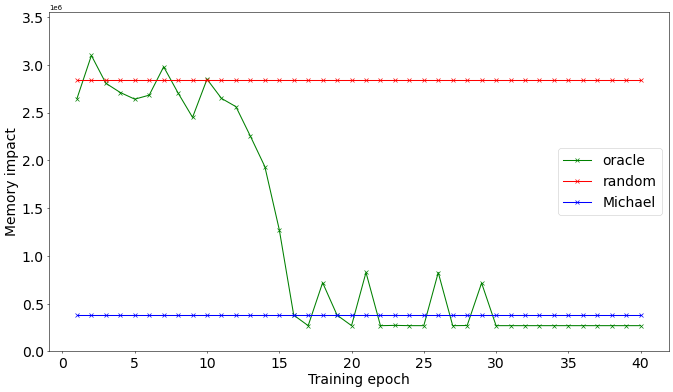

In [12]:
plt.figure(figsize=(16,9),dpi=50)
plt.xlabel('Training epoch',fontsize=20)
plt.ylabel('Memory impact',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,max(max(rnd), max(result))+500000)
plt.plot([x for x in range(1, len(best_result)+1)], best_result, label='oracle',
         linestyle='-', color='g', marker='x', linewidth=1.5)
plt.plot([x for x in range(1, len(rnd)+1)], rnd, label='random',
         linestyle='-', color='r', marker='x', linewidth=1.5)
plt.plot([x for x in range(1, len(michael)+1)], michael, label='Michael',
         linestyle='-', color='b', marker='x', linewidth=1.5)
plt.legend(fontsize=20)